# Overview

<h2>Files</h2>

<B>calendar.csv</B> - Contains information about the dates on which the products are sold.\
<B>sales_train_validation.csv </B>- Contains the historical daily unit sales data per product and store [d_1 - d_1913]\
<B>sample_submission.csv</B> - The correct format for submissions. Reference the Evaluation tab for more info.\
<B>sell_prices.csv</B> - Contains information about the price of the products sold per store and date.\
<B>sales_train_evaluation.csv</B> - Includes sales [d_1 - d_1941] (labels used for the Public leaderboard)

Notes from the official guide

File 1: <I>“calendar.csv”</I> 
Contains information about the dates the products are sold.
- date: The date in a “y-m-d” format.
- wm_yr_wk: The id of the week the date belongs to.
- weekday: The type of the day (Saturday, Sunday, …, Friday).
- wday: The id of the weekday, starting from Saturday.
- month: The month of the date.
- year: The year of the date.
- event_name_1: If the date includes an event, the name of this event.
- event_type_1: If the date includes an event, the type of this event.
- event_name_2: If the date includes a second event, the name of this event.
- event_type_2: If the date includes a second event, the type of this event.
- snap_CA, snap_TX, and snap_WI: A binary variable (0 or 1) indicating whether the stores of CA, TX or WI allow SNAP  purchases on the examined date. 1 indicates that SNAP purchases are allowed.

In the United States, the Supplemental Nutrition Assistance Program (SNAP), formerly yet still commonly known as the Food Stamp Program, is a federal program that provides food-purchasing assistance for low- and no-income people.

Notes from the official guide

File 2: <I>“sales_train.csv”</I> 
Contains the historical daily unit sales data per product and store.
- item_id: The id of the product.
- dept_id: The id of the department the product belongs to.
- cat_id: The id of the category the product belongs to.
- store_id: The id of the store where the product is sold.
- state_id: The State where the store is located.
- d_1, d_2, …, d_i, … d_1941: The number of units sold at day i, starting from 2011-01-29. 

Notes from the official guide

File 3: <I>“sell_prices.csv”</I>
Contains information about the price of the products sold per store and date.
- store_id: The id of the store where the product is sold. 
- item_id: The id of the product.
- wm_yr_wk: The id of the week.
- sell_price: The price of the product for the given week/store. The price is provided per week (average across seven days). If not available, this means that the product was not sold during the examined week. Note that although prices are constant at weekly basis, they may change through time (both training and test set).  


### Business problem

- given historical data of the products, we have to predict sales for the next 28 days.

<b>Why do we need ML solution?</b>

- we need ML solution because there are many things that impacts time series forecasting, eg there may be a trend in data, or the data is not stationary, or there are multiple time series in data where each series is different from another, etc..
- so these thing make problem very very complex which will be very hard to slove using classical stats.
- ML model help us with all these complexities.
- Using ML model we can use other informations(like location, salary, events, etc..) to increase the accuracy of our forecasts.
- so with the help of ML model we can take care of all these things.

## Evaluation Metric

<B>Why not MSE?</B>

in our data there are a lot of values which are zeros, so we will get better result if we predict median i.e. 0.

<B>Why not RMSE?</B>

if we were having single time series then RMSE would be good metric, bcoz denominator would be constant (denominator here means the no of days of sales of a product that we have in the data).

but since here we have many time series, and each time series different form other, each product having different days of sales (ex a product is in market since 12-jan-2011, and other product was released at 12-feb-2015) so both will have diff denominator,


<b>why WRMSSE?</b>
- WRMSSE means weighed root mean squared scaled error\
So to solve this proble we will need a custom metrics which will take care of all these things.\
since all time series are different we would also assign weights to each timeseries.\
weights = total revenue of that time series/ total revenue of all time series

# 1. EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
import gc

## 1.1 Reading Data and basic Stats

In [2]:
# importing datasets
cal= pd.read_csv("calendar.csv")
sales= pd.read_csv("sales_train_evaluation.csv")
price= pd.read_csv("sell_prices.csv")

### calander.csv

In [4]:
cal.head(2)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0


In [5]:
cal.tail(2)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0
1968,2016-06-19,11621,Sunday,2,6,2016,d_1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0


In [3]:
cal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


#### observations

- Our date feature is of object datatype.
- There are null values in ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2'] features.

In [6]:
'''converting date to datetime, and filling all null values'''
cal['date']= pd.to_datetime(cal['date'])
cal.fillna('None', inplace= True)

### sales.csv

In [5]:
sales.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0


In [5]:
print("Total number of states in the data= {}".format(sales['state_id'].nunique()))
print("Total number of stores in the data= {}".format(sales['store_id'].nunique()))
print("Total number of unique category of products in the data= {}".format(sales['cat_id'].nunique()))
print("Total number of unique departments in the data= {}".format(sales['dept_id'].nunique()))
print("Total number of unique products in the data= {}".format(sales['item_id'].nunique()))

Total number of states in the data= 3
Total number of stores in the data= 10
Total number of unique category of products in the data= 3
Total number of unique departments in the data= 7
Total number of unique products in the data= 3049


### price.csv

In [12]:
price.head(2)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58


### 1.2 Downcasting datatypes

In [7]:
def downcasting_datatype(data):
    '''this function downcasts the size of the DataFrame so as to save memory from crashing'''
    for cols in data.columns:
        if data[cols].dtype == 'float64':
            data[cols] = data[cols].astype(np.float32)
        elif data[cols].dtype in ['int64', 'int32']:
            data[cols]= data[cols].astype(np.int16)
    return data
    
#calculating the size of the dataframes before downcasting
cal_size_before= np.round(cal.memory_usage().sum()/1024,1)
sales_size_before= np.round(sales.memory_usage().sum()/(1024*1024),1)
price_size_before= np.round(price.memory_usage().sum()/(1024*1024),1)

'''function calls'''
cal= downcasting_datatype(cal)
sales= downcasting_datatype(sales)
price= downcasting_datatype(price)

#printing the size before downcasting the size of the data
print("Before downcasting the sizes of the dataframes are:" '\n', 
      "cal:",str(cal_size_before)+"+ KB",'\n'  
      'sales:',str(sales_size_before)+"+ MB", '\n' 
      "price:",str(price_size_before)+"+ MB", "\n")

#calculating the size of the dataframes after downcasting
cal_size_after= np.round(cal.memory_usage().sum()/1024,1)
sales_size_after= np.round(sales.memory_usage().sum()/(1024*1024),1)
price_size_after= np.round(price.memory_usage().sum()/(1024*1024),1)

#printing the size after downcasting the size of the data
print("after downcasting the sizes of the dataframes are:" '\n', 
      "cal:",str(cal_size_after)+"+ KB",'\n'  
      'sales:',str(sales_size_after)+"+ MB", '\n' 
      "price:",str(price_size_after)+"+ MB", "\n")

#calculating the percentage reduction of the shape in the data
cal_size_reduction_percentage= np.round((cal_size_after/ cal_size_before) * 100,2)  
sales_size_reduction_percentage= np.round((sales_size_after/ sales_size_before) * 100 ,2) 
sales_size_reduction_percentage= np.round((price_size_after/ price_size_before) * 100 , 2) 

#printing the percentage reduction of the shape in the data
print("percentage reduction in the size of DataFrames:", "\n"
     "cal:", str(cal_size_reduction_percentage)+"% reduction","\n"
     "sales:", str(sales_size_reduction_percentage)+'% reduction',"\n"
     "price:", str(sales_size_reduction_percentage)+"% reduction")

Before downcasting the sizes of the dataframes are:
 cal: 215.5+ KB 
sales: 452.9+ MB 
price: 208.8+ MB 

after downcasting the sizes of the dataframes are:
 cal: 134.7+ KB 
sales: 114.3+ MB 
price: 143.5+ MB 

percentage reduction in the size of DataFrames: 
cal: 62.51% reduction 
sales: 68.73% reduction 
price: 68.73% reduction


- the reduction of memory is very high

In [8]:
'''creating new dataset where each col corresponds to each item, and each row corresponds to sales on a particular date'''
sales_df_cols= sales.columns[6:] #taking all columns 6th onwards
sales_df= sales[sales_df_cols] #new dataframe 
sales_df= sales_df.T
sales_df.columns= sales['id']
sales_df.head()

id,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_010_CA_1_evaluation,...,FOODS_3_818_WI_3_evaluation,FOODS_3_819_WI_3_evaluation,FOODS_3_820_WI_3_evaluation,FOODS_3_821_WI_3_evaluation,FOODS_3_822_WI_3_evaluation,FOODS_3_823_WI_3_evaluation,FOODS_3_824_WI_3_evaluation,FOODS_3_825_WI_3_evaluation,FOODS_3_826_WI_3_evaluation,FOODS_3_827_WI_3_evaluation
d_1,0,0,0,0,0,0,0,12,2,0,...,0,14,1,0,4,0,0,0,0,0
d_2,0,0,0,0,0,0,0,15,0,0,...,0,11,1,0,4,0,0,6,0,0
d_3,0,0,0,0,0,0,0,0,7,1,...,0,5,1,0,2,2,0,0,0,0
d_4,0,0,0,0,0,0,0,0,3,0,...,0,6,1,0,5,2,0,2,0,0
d_5,0,0,0,0,0,0,0,0,0,0,...,0,5,1,0,2,0,0,2,0,0


In [9]:
'''merging sales_df and cal dataframes to get date'''
sales_df.reset_index(inplace= True) 
sales_df= sales_df.rename({'index':'d'}, axis=1) #changing name of col from 'index' to 'd'
sales_df= sales_df.merge(cal[['date','d']], on='d', how='left') #merging dataframes cal and sales_df

sales_df.drop('d',axis=1, inplace= True) #dropping col named 'd'
sales_df['date']= pd.to_datetime(sales_df['date']) #converting date column to datetime
sales_df.set_index('date', inplace= True) #setting date as index
sales_df.head(2)

,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_010_CA_1_evaluation,...,FOODS_3_818_WI_3_evaluation,FOODS_3_819_WI_3_evaluation,FOODS_3_820_WI_3_evaluation,FOODS_3_821_WI_3_evaluation,FOODS_3_822_WI_3_evaluation,FOODS_3_823_WI_3_evaluation,FOODS_3_824_WI_3_evaluation,FOODS_3_825_WI_3_evaluation,FOODS_3_826_WI_3_evaluation,FOODS_3_827_WI_3_evaluation
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0,0,0,0,0,0,0,12,2,0,...,0,14,1,0,4,0,0,0,0,0
2011-01-30,0,0,0,0,0,0,0,15,0,0,...,0,11,1,0,4,0,0,6,0,0


#### Lets see how events impacts the sales of products

In [11]:
'''calculating total sales of all products on each day and merging it with cal dataframe'''
cal_df= pd.DataFrame(sales_df.sum(axis=1))
cal_df.columns=['sales']
cal_df.reset_index(inplace=True)
cal_df= cal_df.merge(cal,on= 'date', how= 'left')
cal_df.head()

,date,sales,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,32631,11101,Saturday,1,1,2011,d_1,None,None,None,None,0,0,0
1,2011-01-30,31749,11101,Sunday,2,1,2011,d_2,None,None,None,None,0,0,0
2,2011-01-31,23783,11101,Monday,3,1,2011,d_3,None,None,None,None,0,0,0
3,2011-02-01,25412,11101,Tuesday,4,2,2011,d_4,None,None,None,None,1,1,0
4,2011-02-02,19146,11101,Wednesday,5,2,2011,d_5,None,None,None,None,1,0,1


In [272]:
'''creating new dataframe which contains total sales on the day of any event'''
events_df= cal_df[(cal_df['event_name_1'] != "None") | (cal_df['event_name_2'] != "None")][['date', 'd', 'sales']]
# events_df= events_df.set_index('date')
events_df.head()

,date,d,sales
8,2011-02-06,d_9,32736
16,2011-02-14,d_17,21804
23,2011-02-21,d_24,23966
39,2011-03-09,d_40,22560
46,2011-03-16,d_47,22765


In [12]:
'''this will get data from cal_df where any of the events are not null'''
events_names= cal_df[(cal_df['event_name_1'] != "None") | 
                     (cal_df['event_name_2'] != "None")][['date','event_name_1', 'event_type_1', 
                                                          'event_name_2', 
                                                          'event_type_2']].reset_index().drop("index", axis=1)
events_names

,date,event_name_1,event_type_1,event_name_2,event_type_2
0,2011-02-06,SuperBowl,Sporting,None,None
1,2011-02-14,ValentinesDay,Cultural,None,None
2,2011-02-21,PresidentsDay,National,None,None
3,2011-03-09,LentStart,Religious,None,None
4,2011-03-16,LentWeek2,Religious,None,None
...,...,...,...,...,...
153,2016-03-27,Easter,Cultural,None,None
154,2016-04-30,Pesach End,Religious,None,None
155,2016-05-01,OrthodoxEaster,Religious,None,None
156,2016-05-05,Cinco De Mayo,Cultural,None,None


In [13]:
'''taking all events in a year so as to store them according to the time they occurrs'''
events_names['year']= events_names['date'].dt.year
events_names_year= events_names[events_names['year']== 2015].copy() #will store names of all events in a year
events_names_year.drop(['date','year'], axis=1, inplace= True)

In [14]:
'''this cell will save events names and events types according to their ocurrance w.r.t. date'''
names= []
types= []
for i in range(len(events_names_year)):
    for j in events_names_year.columns:
        if "name" in j:
            if events_names.iloc[i][j] != 'None':
                names.append(events_names_year.iloc[i][j])
        else:
            if events_names.iloc[i][j] != 'None':
                types.append(events_names_year.iloc[i][j])

In [15]:
names

['NewYear',
 'OrthodoxChristmas',
 'MartinLutherKingDay',
 'SuperBowl',
 'ValentinesDay',
 'PresidentsDay',
 'LentStart',
 'LentWeek2',
 'None',
 'Purim End',
 'StPatricksDay',
 'Easter',
 'Pesach End',
 'OrthodoxEaster',
 'Cinco De Mayo',
 "Mother's day",
 'MemorialDay',
 'NBAFinalsStart',
 'NBAFinalsEnd',
 'Ramadan starts',
 "Father's day",
 'IndependenceDay',
 'Eid al-Fitr',
 'LaborDay',
 'EidAlAdha',
 'ColumbusDay',
 'Halloween',
 'VeteransDay',
 'Thanksgiving',
 'Chanukah End',
 'Christmas']

In [16]:
'''creating a new column called Year in cal_df and events_df'''
cal_df['Year']= cal_df['date'].dt.year
events_df['Year']= events_df['date'].dt.year

In [17]:
events_df.head()

,date,d,sales,Year
8,2011-02-06,d_9,32736,2011
16,2011-02-14,d_17,21804,2011
23,2011-02-21,d_24,23966,2011
39,2011-03-09,d_40,22560,2011
46,2011-03-16,d_47,22765,2011


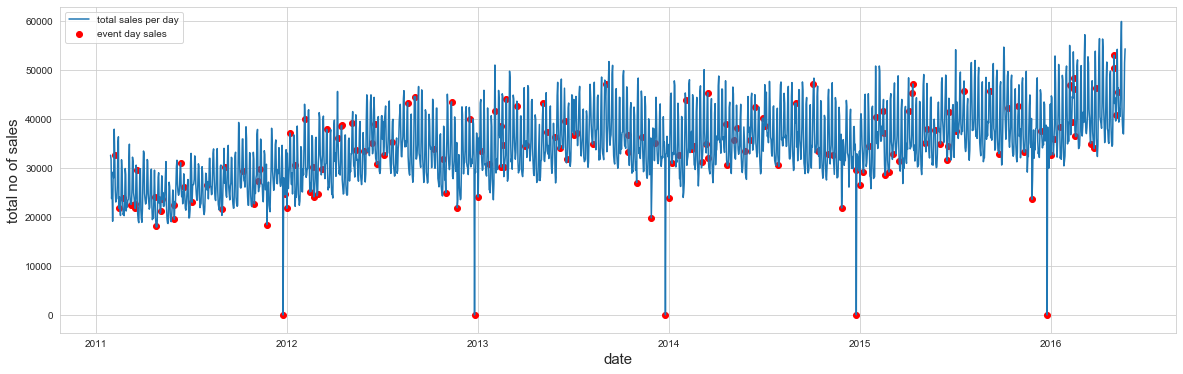

In [104]:
'''plotting total sales on each day and also plotting sales of event day(in red dots)'''
plt.figure(figsize=(20,6))
plt.plot(cal_df['date'], cal_df['sales'], label= 'total sales per day')
plt.scatter(events_df['date'], events_df['sales'], color='red', label='event day sales')
plt.xlabel('date', fontsize=15)
plt.ylabel("total no of sales", fontsize=15)
plt.legend()

<B>Observations</B>
- from the above graph we can see that at the day of most events sale dips, especially for christmas.
- not much is clear from this plot, let's zoom in.

In [123]:
'''Zooming in for a year'''
cal_df_2015= cal_df[cal_df['Year']==2015][['date','d', 'sales']].reset_index(drop=True)
events_df_2015= events_df[events_df['Year']==2015][['date','d', 'sales']].reset_index(drop=True)

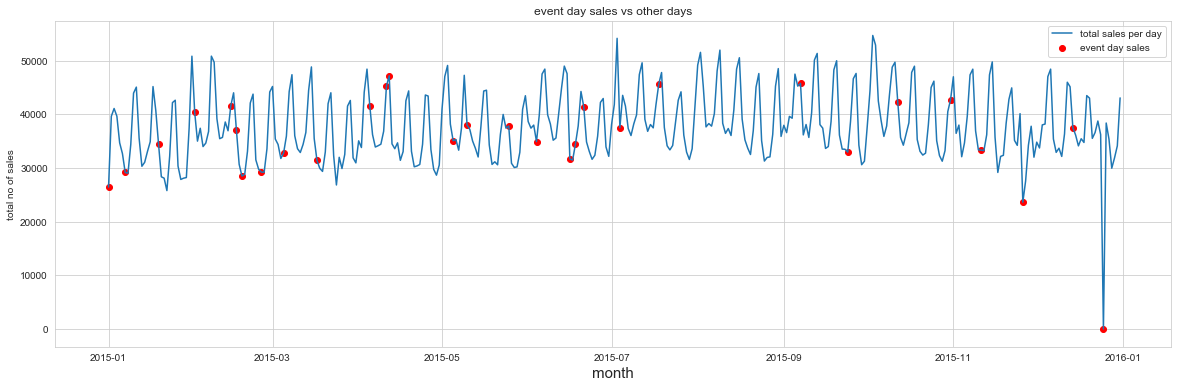

In [124]:
'''only 2015 data'''
plt.figure(figsize=(20,6))
plt.plot(cal_df_2015['date'], cal_df_2015['sales'], label= 'total sales per day')
plt.scatter(events_df_2015['date'], events_df_2015['sales'], color='red', label='event day sales')
plt.xlabel('month', fontsize=15)
plt.ylabel("total no of sales")
plt.title("event day sales vs other days")
plt.legend()

<B>Observations</B>
- from the above graph we can see that at the day of most events sale dips, especially for christmas.
- this could also be because walmart is closed that day.
- there are events on which sales go up this could be because most peoples are celebrating with their families or friends.
- this could also be because most peoples are watching those events like superbowl and partying.

### Mean Event Sales

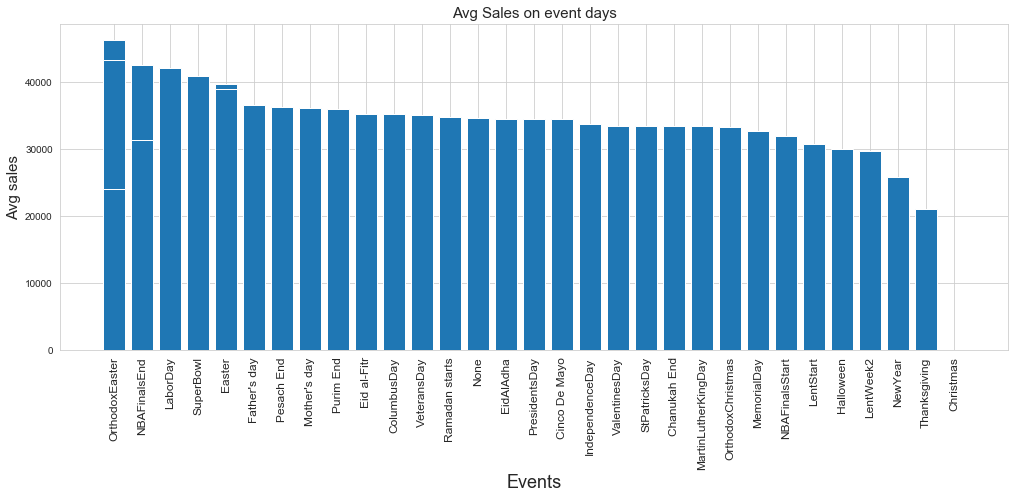

In [162]:
#here we will get all the days of events and then calculate average sales on that day
xx= cal_df.groupby(['event_name_1', 'event_name_2'])['sales'].mean()
xx= pd.DataFrame(xx)
xx.reset_index(inplace= True)
xx= xx.sort_values(by='sales', ascending= False)

plt.figure(figsize=(17,6))
plt.bar(xx['event_name_1'],xx['sales'])
plt.xticks(rotation=90, fontsize=12)
plt.xlabel("Events", fontsize=18)
plt.ylabel("Avg sales", fontsize=15)
plt.title("Avg Sales on event days", fontsize=15)
plt.show()

<B>Observations</B>
- avg sales on days without events are marked with None.
- here we can see that the sales on christmas day is nil, this could be because the walmart is closed that day.
- here we can see that there are event days like Cinco De Mayo(Cinco de Mayo is an annual celebration held on May 5. The date is observed to commemorate the Mexican Army's victory over the French Empire at the Battle of Puebla) on which the sales are way higher.

### Avg sales on one event vs more then one events in a day

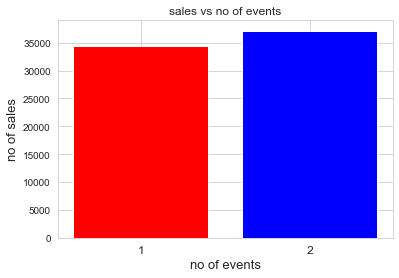

In [172]:
'''here we are getting avg sales when there is one event only and sales when there are more than one event'''
one= cal_df[~((cal_df['event_name_1'] != "None") & (cal_df['event_name_2'] != "None"))]['sales'].mean()
two= cal_df[(cal_df['event_name_1'] != "None") & (cal_df['event_name_2'] != "None")]['sales'].mean()

x=['1', '2']
y= [one,two]

plt.bar(x,y, color=['red','blue'])
plt.title("sales vs no of events")
plt.ylabel("no of sales",fontsize=13)
plt.xlabel("no of events",fontsize=13)
plt.xticks(fontsize=12)
plt.show()

<B>Observations</B>

- from here we can see that on days when there are more than one events the sales are higher.
- this could be because US is culturally diverse, so some people may be celebrating one event and some may be celebrating other event.
- some people may be celebrating easter, while some may not.

### amount of sales per store

In [15]:
price= pd.read_csv("sell_prices.csv")

In [16]:
sales_by_store= price.groupby('store_id')['sell_price'].agg('sum').reset_index()
sales_by_store.head()

,store_id,sell_price
0,CA_1,3.082953e+06
1,CA_2,2.833540e+06
2,CA_3,3.045387e+06
3,CA_4,3.002363e+06
4,TX_1,3.061306e+06


Text(0.5, 1.0, 'amount of sales per store')

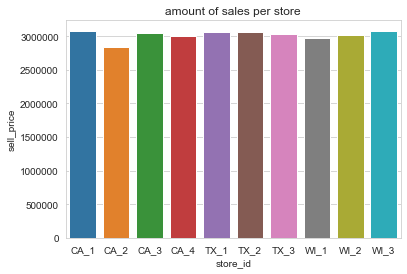

In [17]:
sns.barplot('store_id', 'sell_price', data= sales_by_store)
plt.title('amount of sales per store')

<B>Observations</B>
- from here we can see that the even though the population of wisconsin is very small compared to other states, it spends nearly same as other two states, this may be because of the fact that the annual average income is high.
- we can also see that amount of sales in store CA_2 are lower than than other stores, this could be because the population of that area is lower or the price of items on that store is higher.

In [81]:
'''these functions will help us in plotting'''

#plotting a line plot
def plot(data, index, name): #input is dataframe, indexes of that dataframe, name u want in Label
    '''this function will plot the data'''
    plt.figure(figsize=(15,7))
    for i in range(len(data)):
        plt.plot(data.iloc[i], label= index[i])
    plt.legend()
    plt.xlabel('date', fontsize= 15)
    plt.xticks(range(0,len(data.columns),90), rotation=45, fontsize= 12)
    plt.ylabel("no of sales", fontsize= 15)
    plt.title(f'no of sales by {name}', fontsize= 15)
    plt.show()
    
#plotting with rolling feature
def rolling_plot(data, index, name, window_size): #dataframe, indexes , name u want in label, and rolling window size
    #rolling
    by_data_roll= data.T
    by_data_roll_col= by_data_roll.columns
    for i in by_data_roll.columns:
        by_data_roll[i+'roll']= by_data_roll[i].rolling(window_size).mean()

    by_data_roll= by_data_roll.drop(by_data_roll_col,axis=1).dropna()
    by_data_roll= by_data_roll.T
    
    plt.figure(figsize=(15,7))
    for i in range(len(data)):
        plt.plot(by_data_roll.iloc[i], label= index[i])
    plt.legend()
    plt.xlabel('date')
    plt.xticks(range(0,len(data.columns),90), rotation=45, fontsize= 12)
    plt.ylabel("no of sales")

    plt.title(f'no of sales by {name}')
    plt.show()
    
def plot_hist(data, name): #for plotting histogram
    plt.figure(figsize=(10,5))
    for_hist= pd.DataFrame(data.sum(axis=1), columns=['total_sales'])
#     https://showmecode.info/matplotlib/bar/change-bar-color/  for diff color bars
    plt.bar(for_hist.index, for_hist.total_sales, color=['red', 'blue', 'green', 'yellow', 'lavender', 'orange', 'black', 'brown', 'pink', 'purple'])
    plt.ylabel("Total Sales", fontsize= 15)
    plt.xlabel(name, fontsize= 15)
    plt.title(f'Total Sales by {name}', fontsize= 15)

# sales

In [19]:
sales.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0


In [194]:
d_cols= [col for col in sales.columns if "d_" in col] #contains col names with d_

### Max and Min selling product in each state

In [268]:
'''this function will get the max and min salling product from respective category'''
def max_min(data, name):
    for i in data[name].unique():
        df= data.groupby([name]).get_group(i)
        df= df[['item_id'] + d_cols]
        df['total']= df[d_cols].sum(axis=1)
        max_sales= max(df['total'])
        min_sales= min(df['total'])
        item_max= df[df['total']== max_sales]['item_id'].values[0]
        item_min= df[df['total']== min_sales]['item_id'].values[0]
        print(f'Max selling product in {name.split("_")[0]} {i} is {item_max} with sales= {max_sales}')
        print(f'Min selling product in {name.split("_")[0]} {i} is {item_min} with sales= {min_sales} \n')

In [267]:
max_min(sales, 'state_id')

Max selling product in state CA is FOODS_3_090 with sales= 253859
Min selling product in state CA is FOODS_3_778 with sales= 15 

Max selling product in state TX is FOODS_3_586 with sales= 195120
Min selling product in state TX is FOODS_2_071 with sales= 18 

Max selling product in state WI is FOODS_3_090 with sales= 123500
Min selling product in state WI is FOODS_2_057 with sales= 16 



### Max and Min selling product in each store

In [266]:
max_min(sales, 'store_id')

Max selling product in store CA_1 is FOODS_3_090 with sales= 128855
Min selling product in store CA_1 is HOUSEHOLD_1_378 with sales= 23 

Max selling product in store CA_2 is FOODS_3_586 with sales= 64421
Min selling product in store CA_2 is FOODS_3_778 with sales= 15 

Max selling product in store CA_3 is FOODS_3_090 with sales= 253859
Min selling product in store CA_3 is HOUSEHOLD_1_020 with sales= 23 

Max selling product in store CA_4 is FOODS_3_090 with sales= 52955
Min selling product in store CA_4 is HOUSEHOLD_2_216 with sales= 23 

Max selling product in store TX_1 is FOODS_3_586 with sales= 114010
Min selling product in store TX_1 is HOBBIES_2_025 with sales= 28 

Max selling product in store TX_2 is FOODS_3_586 with sales= 195120
Min selling product in store TX_2 is FOODS_2_209 with sales= 24 

Max selling product in store TX_3 is FOODS_3_586 with sales= 151862
Min selling product in store TX_3 is FOODS_2_071 with sales= 18 

Max selling product in store WI_1 is FOODS_3_226 w

### sales by state

In [173]:
by_state= sales.groupby('state_id').sum()
by_state_ind= by_state.index

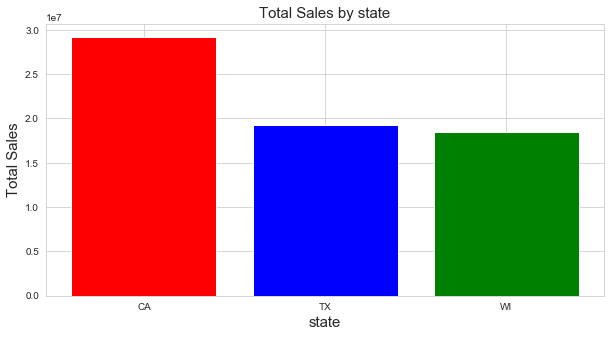

In [21]:
plot_hist(by_state, 'state')

- from here we can see that no of sales are most in californa, this may be because of higher population.
- from here we can see that the even though the population of wisconsin is very small compared to other states, it spends nearly same as other two states, this may be because of the fact that the annual average income is high.

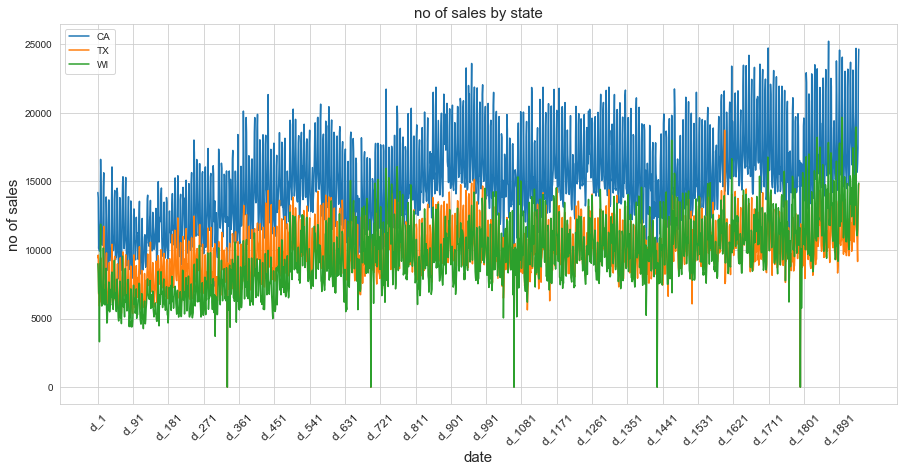

In [82]:
plot(by_state, by_state_ind, 'state')

<B>Observations</B>
- we can see that no of sales in california is higher.
- not much is clear from this, lets plot a rolling mean of sales.

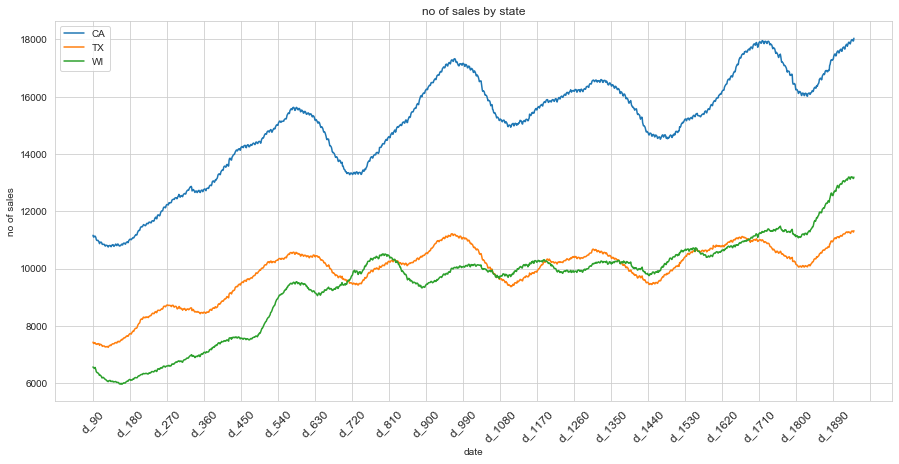

In [83]:
#rolling window vs date
#taking rolling window of 90 days
rolling_plot(by_state, by_state_ind, 'state', 90) #(dataframe, index of dataframe, name for title, window size)

<B>Observations</B>
- most no of items are sold in california, because of their higher population.
- there is uptrend in the no of sales per state
- even though population of wisconsin is very small compared ot texas, the no of items sold are similar to texas, and the sales of items is increasing at a faster pace than texas.

### sales by dept 

In [84]:
by_dept= sales.groupby('dept_id').sum()
by_dept_ind= by_dept.index

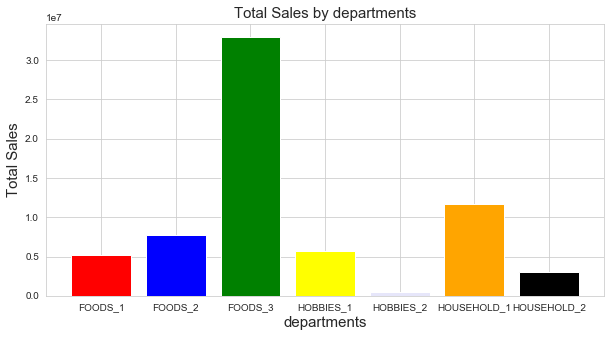

In [85]:
plot_hist(by_dept, 'departments')

<B>Observations</B>
- most no of sales happens in FOOD_3 department. this could be because these items are snacks or these items are cheap.
- we can also see that there are very low sales in HOBBIES_2 department, this could be because these items are very costly, or it could be because not many people have hobbies that requires these items.

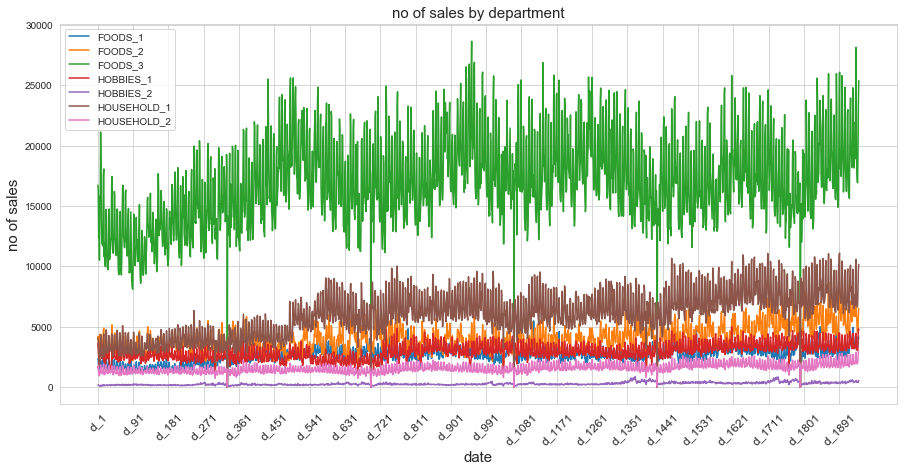

In [86]:
plot(by_dept, by_dept_ind, 'department')

<B>Observations</B>
- Foods_3 category is the one that's sold most. 
- we can see that there is seasonality in the data.
- lets plot a rolling avg sales to get a clearer picture.

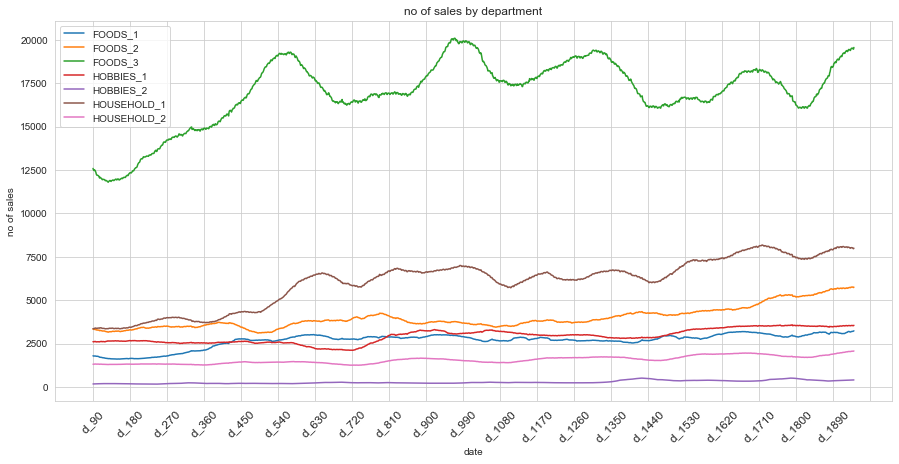

In [87]:
#rolling window vs date
#taking rolling window of 90 days
rolling_plot(by_dept, by_dept_ind, 'department', 90) #(dataframe, index of dataframe, name for title, window size)

<B>Observations</B>
- Foods_3 category is the one that's sold most. 
- from here we can also see that there is an uptrend in Foods_3, Househould_2 and Foods_2 category.
- we can also see that sales in few department have near consistent sales.

### sales by category

In [88]:
by_cat= sales.groupby('cat_id').sum()
by_cat_ind= by_cat.index

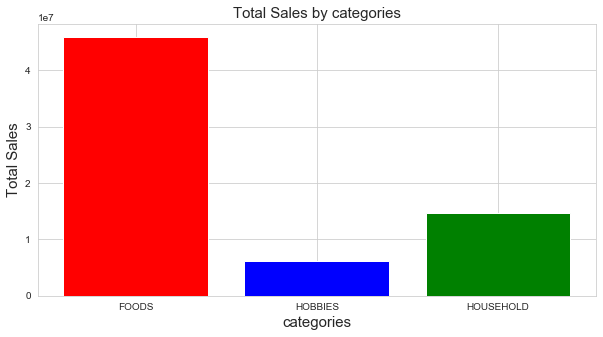

In [89]:
plot_hist(by_cat, 'categories')

- as expected, most no of sales happens in FOODS category.
- items in hobbies categories are sold less, this could be because most people buy equipments only when their own equipment or items gets old. example- people won't buy surfboard everyday.

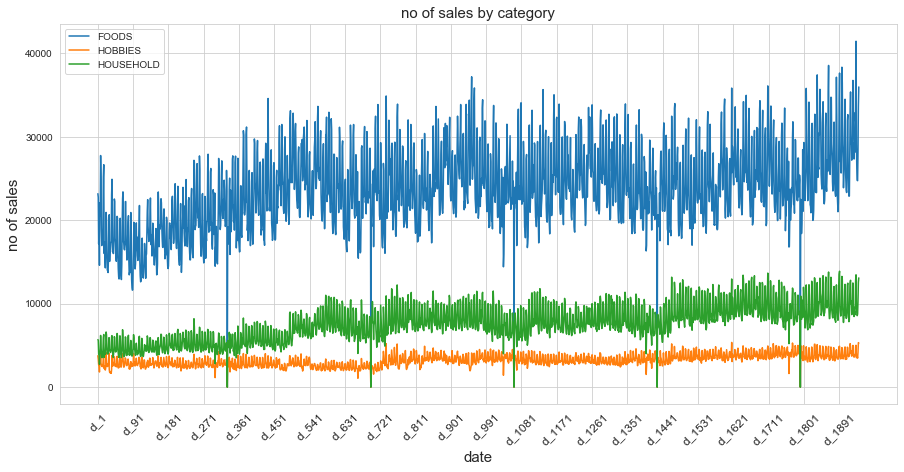

In [90]:
plot(by_cat, by_cat_ind, 'category')

<B>Observations</B>
- Foods items are sold most. 
- we can see that there is seasonality in the data.
- let's plot rolling acg sales to check trends, we can get a clearer plot then.

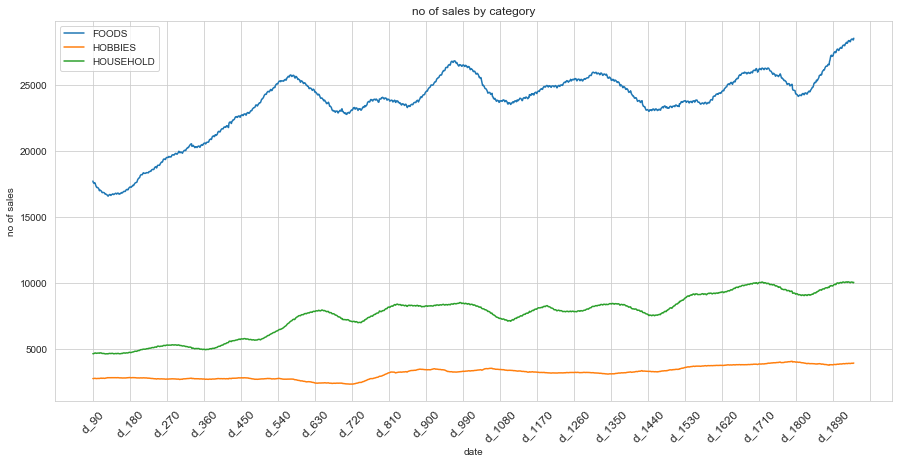

In [91]:
#rolling window vs date
#taking rolling window of 90 days
rolling_plot(by_cat, by_cat_ind, 'category', 90) #(dataframe, index of dataframe, name for title, window size)

<B>Observations</B>
- Foods items are sold most. 
- we can see uptrends in foods department and hobbies department.
- hobbies items sales are pretty much near consistent.

#### sales by store

In [92]:
by_store= sales.groupby('store_id').sum()
by_store_ind= by_store.index

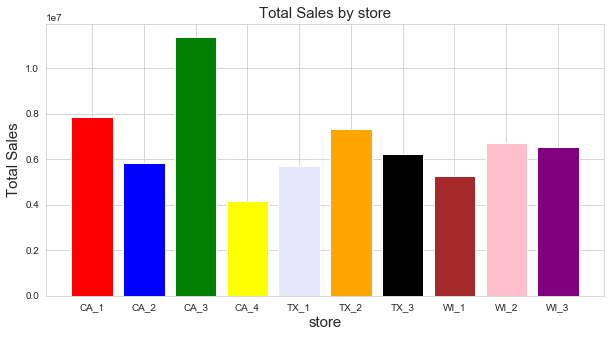

In [93]:
plot_hist(by_store, 'store')

<B>Observations</B>
- store CA_3 sells most no of items, this may be because of population or location, each store is affected by these conditions.
- even though the population of wisconsin is very low compared to other states, the stores in wisconsin sells more than few stores in california.
- the no of sales at stores in california has very high differences, this could also be because of income disparity amoung peoples.

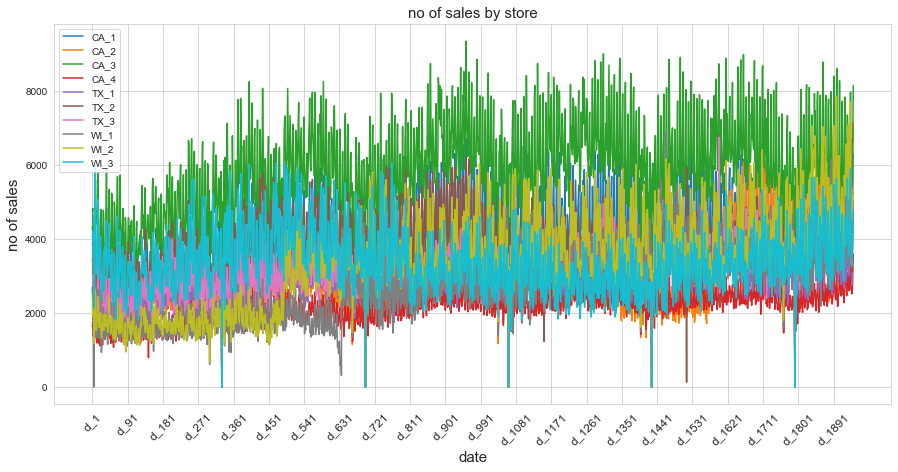

In [94]:
plot(by_store, by_store_ind, 'store')

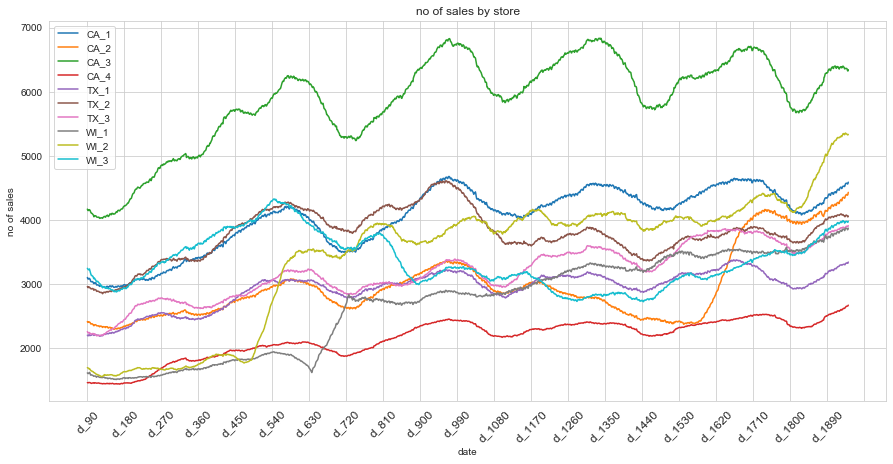

In [95]:
#rolling window vs date
#taking rolling window of 90 days
rolling_plot(by_store, by_store_ind, 'store', 90) #(dataframe, index of dataframe, name for title, window size)

<B>Observations</B> 
- there is an uptrend on sales by store.
- Store CA_3 is the store which solds the most no of items, may be because the population in that area is higher.
- sales at stores in california are growing at different rates, this can also mean that the areas near those stores are growing at a diff rate.

#### EDA per item

#### Taking 3 samples from sales data

In [19]:
#taking 3 samples and plotting them
sales_df_cols= sales_df.columns
ind=[500,15000,30000]
sample_id=[]
samples=[]
for i in ind:
    sample_id.append(sales_df_cols[i])
    samples.append(sales_df[sales_df_cols[i]])
# sample_1_id, sample_1= sales_df_cols[500], sales_df[sales_df_cols[500]]
# sample_2_id, sample_2= sales_df_cols[15000], sales_df[sales_df_cols[15000]]
# sample_3_id, sample_3= sales_df_cols[30000], sales_df[sales_df_cols[30000]]

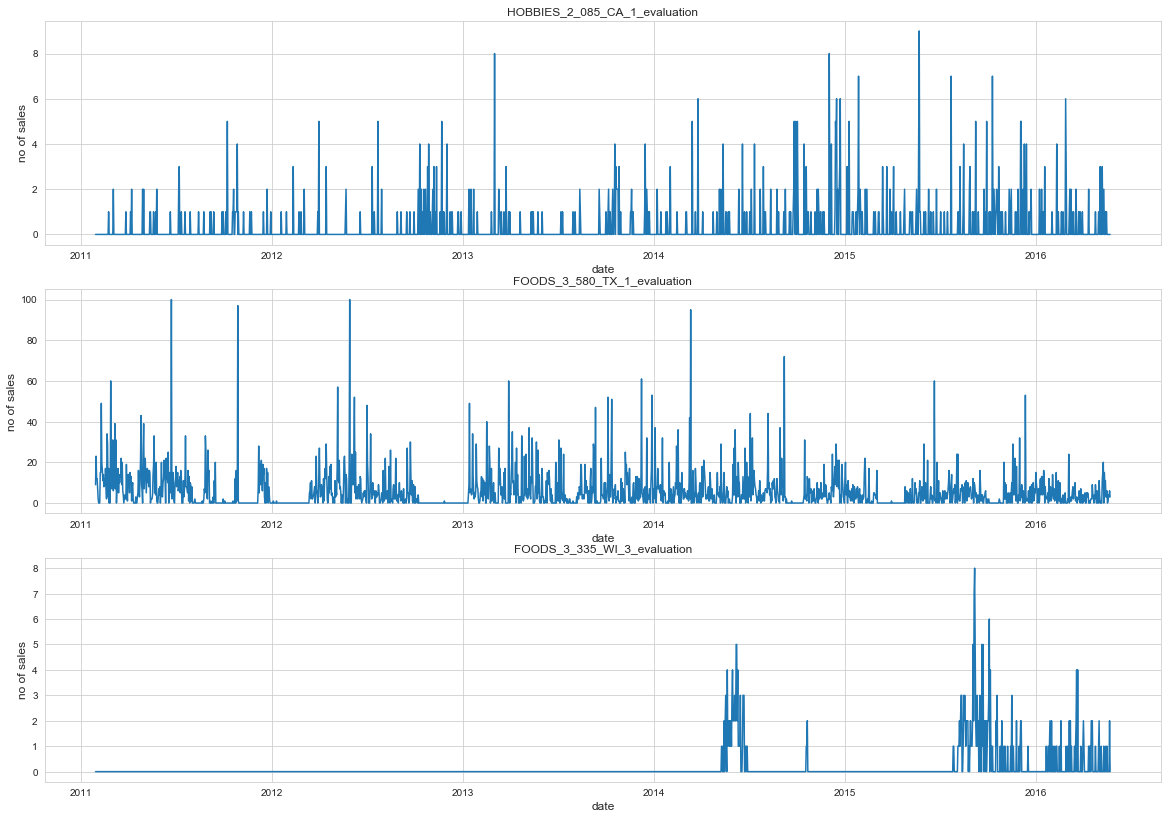

In [20]:
plt.figure(figsize= (20,14))
for i in range(len(ind)):
    plt.subplot(3,1,i+1)
    plt.plot(samples[i])
    plt.title(sample_id[i], fontsize=12)
    plt.xlabel('date', fontsize=12)
    plt.ylabel('no of sales', fontsize=12)

- from the above pllot its clear that our data is erratic in nature as there are days when the sales are very high, and some days when the sales are 0, could be beause the product was out of store.
- zero sales at the beginning denote that product was not yet available in the market.

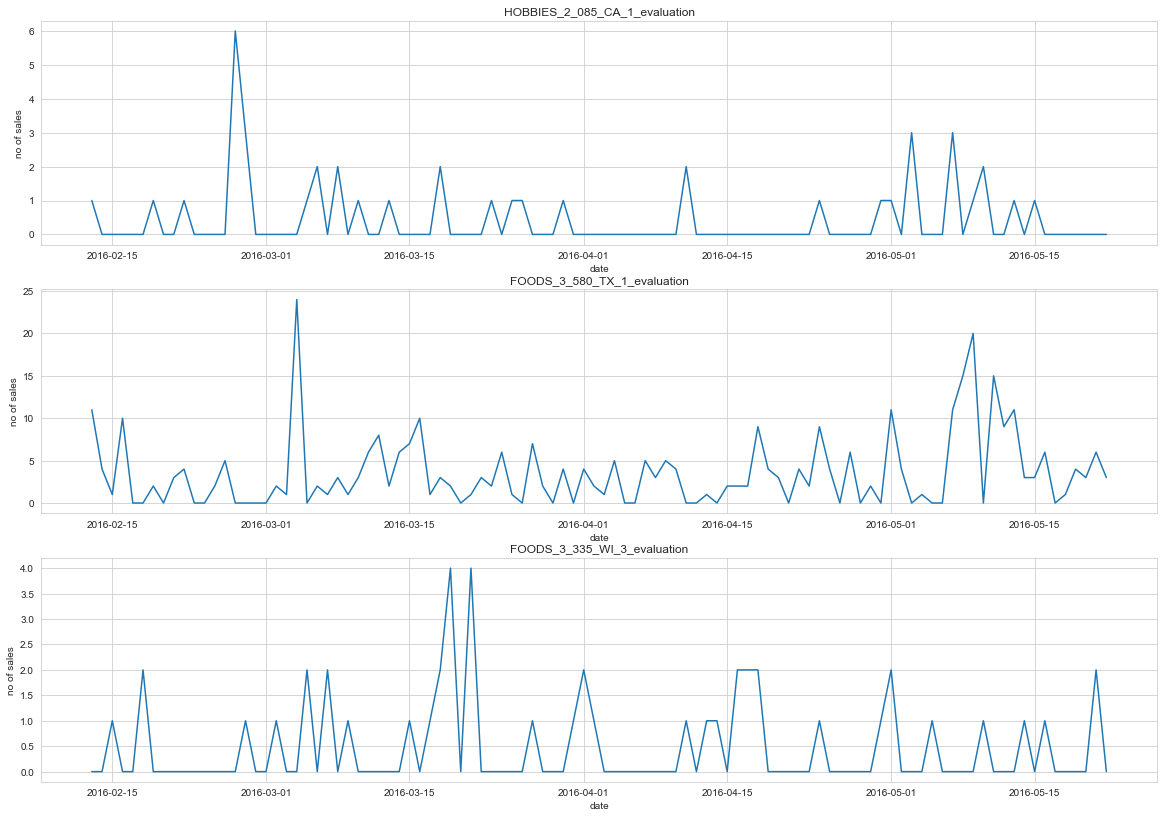

In [122]:
#zooming in 
last_100_values= [] #will store last 100 values of the samples
for i in samples:
    last_100_values.append(i[-100:])
    
plt.figure(figsize= (20,14)) #plotting those values
for i in range(len(ind)):
    plt.subplot(3,1,i+1)
    plt.plot(last_100_values[i])
    plt.title(sample_id[i])
    plt.xlabel('date')
    plt.ylabel('no of sales')

- From the above plots it is clear that timeseries data for each product is intermittent in nature, it even hits zero multiple times,
- Sometime there are no sales for days, which may also mean that the product was out of stock, or no one bought the product,
- There are sales which starts with zero and continue like that for a long time, this may mean that the product has not yet hit the market.

#### checking the distribution of sales of a product in different stores in one state

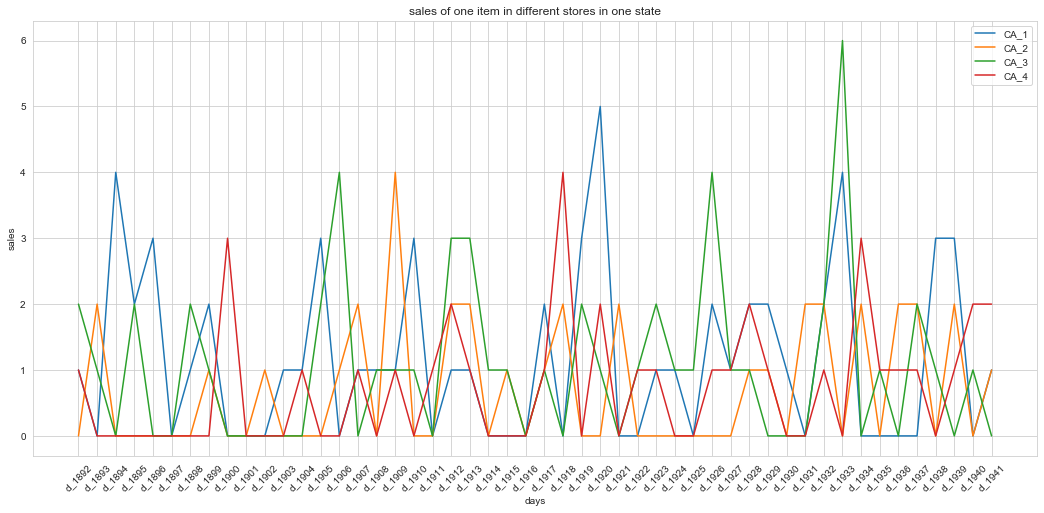

In [3]:
sas= sales.groupby(['item_id', 'state_id']).get_group(('HOBBIES_1_001', "CA"))
sas= sas[sas.columns[6:]]
sas= sas[sas.columns[-50:]]
sas= sas.T

plt.figure(figsize=(18,8))
plt.plot(sas)
plt.title('sales of one item in different stores in one state')
plt.xlabel('days')
plt.ylabel('sales')
plt.xticks(rotation=45)
plt.legend(['CA_1', 'CA_2', 'CA_3', 'CA_4'])
plt.show()

<B>Obsrervations</B>

- From this plot we can see that the distribution of the sales of a product across each store in one state is differen.
- This means we will have to model our data for each product across each store.
- 3049 products, 10 stores, so there will be a total of 30490 timeseries.

### Denoising our data using moving averages

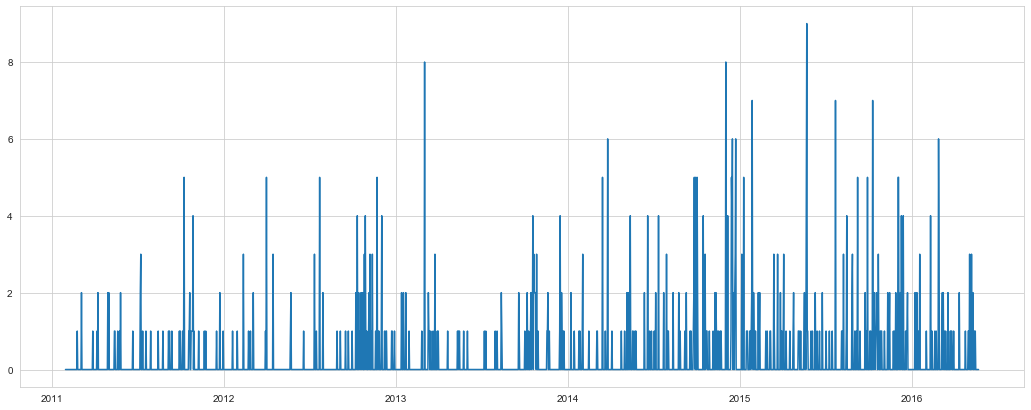

In [150]:
#plotting one of the sample from above
plt.figure(figsize=(18,7))
plt.plot(sales_df[sales_df_cols[500]])

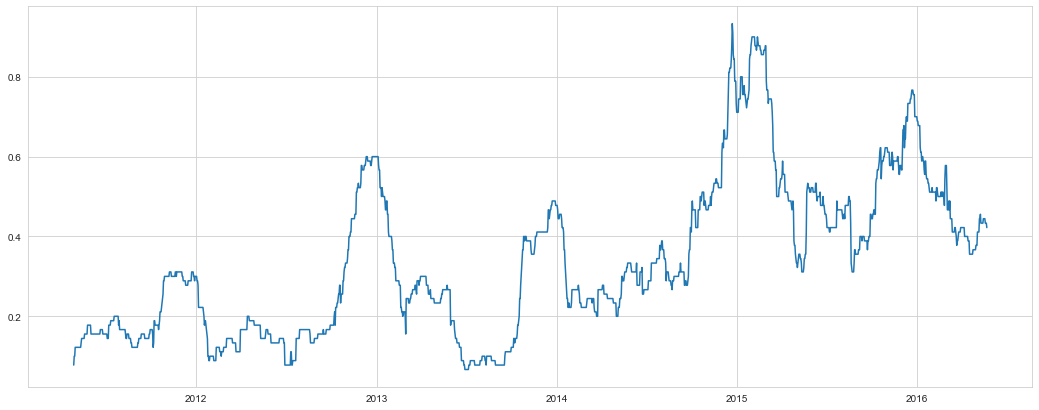

In [159]:
#plotting the denoised sample
plt.figure(figsize=(18,7))
plt.plot(sales_df[sales_df_cols[500]].rolling(90).mean())

- from here we can see that the data of sales of the product follow uptrend.
- we can also see that the sale of this item goes up at the end of the year, this could be because this item could be related to winter, ex. skis for skeeing as in winter there could be snow.
- the data does not look stationary, lets check with Augmented dickey fuller test to check if this series is stationary or not.

### Checking for stationarity using Augmented dickey fuller test

In [33]:
#here we are taking one of the above sample to check for stationarity
x1= sales_df[sales_df_cols[500]]
x1.head()

date
2011-01-29    0
2011-01-30    0
2011-01-31    0
2011-02-01    0
2011-02-02    0
Name: HOBBIES_2_085_CA_1_evaluation, dtype: int16

In [34]:
#converting it to object of dataframe
x1= pd.DataFrame(x1)
x1.head()

,HOBBIES_2_085_CA_1_evaluation
date,
2011-01-29,0
2011-01-30,0
2011-01-31,0
2011-02-01,0
2011-02-02,0


In [36]:
#we are checking the stationarity using adfuller test
#this is a statistic test 
#here H0= time series is not stationary
#H1= time series is stationary

from statsmodels.tsa.stattools import adfuller

print('Results of Dickey Fuller Test')
dftest= adfuller(x1['HOBBIES_2_085_CA_1_evaluation'], autolag= 'AIC')
dfoutput= pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
                                 dfoutput['Critical Value (%s)'%key]= value
        
print(dfoutput)

Results of Dickey Fuller Test
Test Statistic                -8.195774e+00
p-value                        7.456640e-13
#Lags Used                     1.600000e+01
Number of Observations Used    1.924000e+03
Critical Value (1%)           -3.433753e+00
Critical Value (5%)           -2.863043e+00
Critical Value (10%)          -2.567570e+00
dtype: float64


<B>Observations</B>
- from here we can see that the p-value is <0.05 so we reject our null hypothesis and accept that our timeseries is stationary.

In [ ]:
#melting the data
#using this we can transform our dataframe from wide to long format.

# https://www.youtube.com/watch?v=kJsiiPK5sxs
data = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
             , var_name='d', value_name='sales').dropna()

In [ ]:
#combining calander and sell_price datataframe twith data to create one single dataframe
data = pd.merge(data, cal, on='d', how='left')
data = pd.merge(data, price, on=['store_id','item_id','wm_yr_wk'], how='left') 

In [ ]:
data.to_pickle("merged_data.pkl") #saving it as pickle file bcoz csv takes more space

In [275]:
# data= pd.read_pickle('merged_data.pkl')
# data.head()

,state_id,store_id,cat_id,dept_id,item_id,id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,CA,CA_1,HOBBIES,HOBBIES_1,HOBBIES_1_001,HOBBIES_1_001_CA_1_evaluation,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
1,CA,CA_1,HOBBIES,HOBBIES_1,HOBBIES_1_001,HOBBIES_1_001_CA_1_evaluation,d_2,0,2011-01-30,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2,CA,CA_1,HOBBIES,HOBBIES_1,HOBBIES_1_001,HOBBIES_1_001_CA_1_evaluation,d_3,0,2011-01-31,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
3,CA,CA_1,HOBBIES,HOBBIES_1,HOBBIES_1_001,HOBBIES_1_001_CA_1_evaluation,d_4,0,2011-02-01,11101,...,2,2011,NaN,NaN,NaN,NaN,1,1,0,NaN
4,CA,CA_1,HOBBIES,HOBBIES_1,HOBBIES_1_001,HOBBIES_1_001_CA_1_evaluation,d_5,0,2011-02-02,11101,...,2,2011,NaN,NaN,NaN,NaN,1,0,1,NaN


In [38]:
#deleting previous loaded files, so as to free memory
del cal, sales, price
gc.collect() #for garbage collection

7140

In [12]:
data.head()

,state_id,store_id,cat_id,dept_id,item_id,id,d,sales,date,wm_yr_wk,...,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,revenue
0,CA,CA_1,HOBBIES,HOBBIES_1,HOBBIES_1_001,HOBBIES_1_001_CA_1_evaluation,d_1,0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN
1,CA,CA_1,HOBBIES,HOBBIES_1,HOBBIES_1_001,HOBBIES_1_001_CA_1_evaluation,d_2,0,2011-01-30,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN
2,CA,CA_1,HOBBIES,HOBBIES_1,HOBBIES_1_001,HOBBIES_1_001_CA_1_evaluation,d_3,0,2011-01-31,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN
3,CA,CA_1,HOBBIES,HOBBIES_1,HOBBIES_1_001,HOBBIES_1_001_CA_1_evaluation,d_4,0,2011-02-01,11101,...,2011,NaN,NaN,NaN,NaN,1,1,0,NaN,NaN
4,CA,CA_1,HOBBIES,HOBBIES_1,HOBBIES_1_001,HOBBIES_1_001_CA_1_evaluation,d_5,0,2011-02-02,11101,...,2011,NaN,NaN,NaN,NaN,1,0,1,NaN,NaN


### no of sales on event days per state

In [339]:
def event_sales(df, name): #ca_events= data.groupby(['state_id']).get_group('CA')
    plt.figure(figsize=(17,6))
    title= name.split('_')[0]
    for i in df[name].unique():
        ev_df= df.groupby([name]).get_group(i)
        events_days_only= ev_df[(ev_df['event_name_1'] != 'None') | (ev_df['event_name_2'] != 'None')]
        event_day_sales= events_days_only.groupby('date')['sales'].sum()
        plt.plot(event_day_sales, label=i)
        plt.xlabel('date', fontsize=14)
        plt.ylabel('no of sales', fontsize=14)
    plt.title(f"no of sales on event days per {title}")
    plt.legend(fontsize=(12))

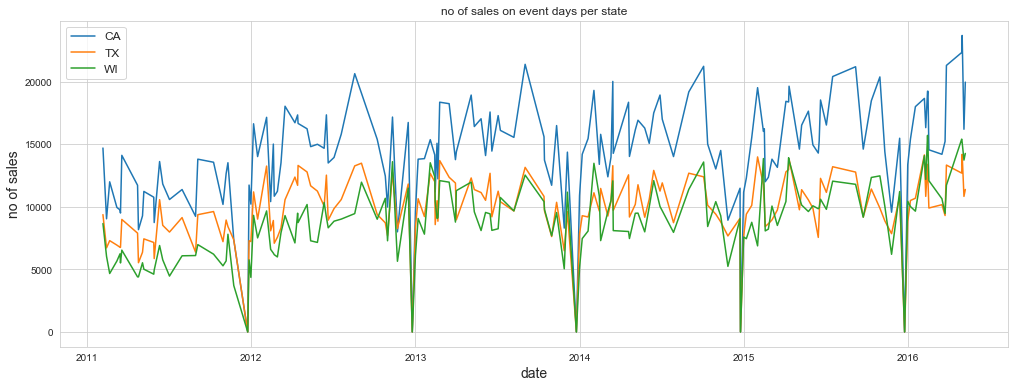

In [340]:
event_sales(data, 'state_id')

<B>Observations</B>
- from here we can see that the sales on event days in california are higher, this could be because the population of california is very high compared to other states.
- enen though the population of wisconsin is very less compared to texas, the sales on the events days is similar for both states.

### no of sales on event days per store

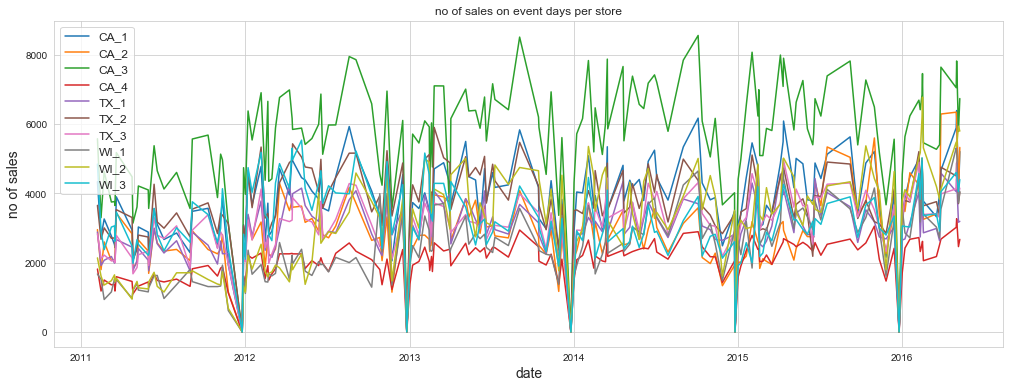

In [341]:
event_sales(data, 'store_id')

<B>Observations</B>
- from the plot we can see that sales on events days is higher in store CA_3, this could be because the population is higher in that region or it could be because the avg salary in that region is higher.
- there is much diff in the sales by the stores of california.

## data_preprocessing

In [18]:
#filling all the nan values in these features
data['event_name_1'].fillna("None", inplace=True)
data['event_type_1'].fillna("None", inplace=True)
data['event_name_2'].fillna("None", inplace=True)
data['event_type_2'].fillna("None", inplace=True)

In [19]:
data.head()

,state_id,store_id,cat_id,dept_id,item_id,id,d,sales,date,wm_yr_wk,...,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,revenue
0,CA,CA_1,HOBBIES,HOBBIES_1,HOBBIES_1_001,HOBBIES_1_001_CA_1_evaluation,d_1,0,2011-01-29,11101,...,2011,None,None,None,None,0,0,0,NaN,NaN
1,CA,CA_1,HOBBIES,HOBBIES_1,HOBBIES_1_001,HOBBIES_1_001_CA_1_evaluation,d_2,0,2011-01-30,11101,...,2011,None,None,None,None,0,0,0,NaN,NaN
2,CA,CA_1,HOBBIES,HOBBIES_1,HOBBIES_1_001,HOBBIES_1_001_CA_1_evaluation,d_3,0,2011-01-31,11101,...,2011,None,None,None,None,0,0,0,NaN,NaN
3,CA,CA_1,HOBBIES,HOBBIES_1,HOBBIES_1_001,HOBBIES_1_001_CA_1_evaluation,d_4,0,2011-02-01,11101,...,2011,None,None,None,None,1,1,0,NaN,NaN
4,CA,CA_1,HOBBIES,HOBBIES_1,HOBBIES_1_001,HOBBIES_1_001_CA_1_evaluation,d_5,0,2011-02-02,11101,...,2011,None,None,None,None,1,0,1,NaN,NaN


In [20]:
#feature named 'd' has values like d_1, we are only taking 1...
data['d']= data['d'].apply(lambda x: x.split("_")[1])

In [21]:
data.head()

,state_id,store_id,cat_id,dept_id,item_id,id,d,sales,date,wm_yr_wk,...,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,revenue
0,CA,CA_1,HOBBIES,HOBBIES_1,HOBBIES_1_001,HOBBIES_1_001_CA_1_evaluation,1,0,2011-01-29,11101,...,2011,None,None,None,None,0,0,0,NaN,NaN
1,CA,CA_1,HOBBIES,HOBBIES_1,HOBBIES_1_001,HOBBIES_1_001_CA_1_evaluation,2,0,2011-01-30,11101,...,2011,None,None,None,None,0,0,0,NaN,NaN
2,CA,CA_1,HOBBIES,HOBBIES_1,HOBBIES_1_001,HOBBIES_1_001_CA_1_evaluation,3,0,2011-01-31,11101,...,2011,None,None,None,None,0,0,0,NaN,NaN
3,CA,CA_1,HOBBIES,HOBBIES_1,HOBBIES_1_001,HOBBIES_1_001_CA_1_evaluation,4,0,2011-02-01,11101,...,2011,None,None,None,None,1,1,0,NaN,NaN
4,CA,CA_1,HOBBIES,HOBBIES_1,HOBBIES_1_001,HOBBIES_1_001_CA_1_evaluation,5,0,2011-02-02,11101,...,2011,None,None,None,None,1,0,1,NaN,NaN


## Feature Engineering

#### Revenue generated

In [ ]:
#Revenue generated= no of sales of product * selling price of product
data['revenue'] = data['sales']*data['sell_price'].astype(np.float32)

#### creating lags features

In [33]:
lags = [1,2,3,7,14,21,28]
for lag in lags:
    data['lag_'+str(lag)] = data.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],as_index=False)['sales'].shift(lag).astype(np.float16)

In [34]:
data.head()

,state_id,store_id,cat_id,dept_id,item_id,id,d,sales,date,wm_yr_wk,...,snap_WI,sell_price,revenue,lag_1,lag_2,lag_3,lag_7,lag_14,lag_21,lag_28
0,CA,CA_1,HOBBIES,HOBBIES_1,HOBBIES_1_001,HOBBIES_1_001_CA_1_evaluation,1,0,2011-01-29,11101,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CA,CA_1,HOBBIES,HOBBIES_1,HOBBIES_1_001,HOBBIES_1_001_CA_1_evaluation,2,0,2011-01-30,11101,...,0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,CA,CA_1,HOBBIES,HOBBIES_1,HOBBIES_1_001,HOBBIES_1_001_CA_1_evaluation,3,0,2011-01-31,11101,...,0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,CA,CA_1,HOBBIES,HOBBIES_1,HOBBIES_1_001,HOBBIES_1_001_CA_1_evaluation,4,0,2011-02-01,11101,...,0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN
4,CA,CA_1,HOBBIES,HOBBIES_1,HOBBIES_1_001,HOBBIES_1_001_CA_1_evaluation,5,0,2011-02-02,11101,...,1,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN


#### rolling mean feature

In [35]:
window_size = [1,2,3,7,14,21,28, 60, 90]

for win in window_size:
    data['rolling_mean'+str(win)] = data.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sales'].transform(lambda x: x.rolling(window= win).mean()).astype(np.float16)

In [36]:
data.head()

,state_id,store_id,cat_id,dept_id,item_id,id,d,sales,date,wm_yr_wk,...,lag_28,rolling_mean1,rolling_mean2,rolling_mean3,rolling_mean7,rolling_mean14,rolling_mean21,rolling_mean28,rolling_mean60,rolling_mean90
0,CA,CA_1,HOBBIES,HOBBIES_1,HOBBIES_1_001,HOBBIES_1_001_CA_1_evaluation,1,0,2011-01-29,11101,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CA,CA_1,HOBBIES,HOBBIES_1,HOBBIES_1_001,HOBBIES_1_001_CA_1_evaluation,2,0,2011-01-30,11101,...,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CA,CA_1,HOBBIES,HOBBIES_1,HOBBIES_1_001,HOBBIES_1_001_CA_1_evaluation,3,0,2011-01-31,11101,...,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,CA,CA_1,HOBBIES,HOBBIES_1,HOBBIES_1_001,HOBBIES_1_001_CA_1_evaluation,4,0,2011-02-01,11101,...,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,CA,CA_1,HOBBIES,HOBBIES_1,HOBBIES_1_001,HOBBIES_1_001_CA_1_evaluation,5,0,2011-02-02,11101,...,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
# data.to_pickle("final_data.pkl")

In [3]:
data= pd.read_pickle('final_data.pkl')

#### Label encoding

In [ ]:
#label encoding all categorical features
#not using one hot encoding, because we have featues which have large no of unique values
#ex. we have 3049 unique items, using one hot encoding means creating 3049 features

from sklearn.preprocessing import LabelEncoder
le= LabelEncoder()

#label encoding states
data['state_id_encoded']= le.fit_transform(data['state_id'])
l= len(data['state_id'].unique())
state_id_dict= dict(zip(range(l), list(le.inverse_transform(range(l)))))

#label encoding stores
data['store_id_encoded']= le.fit_transform(data['store_id'])
l= len(data['store_id'].unique())
store_id_dict= dict(zip(range(l), list(le.inverse_transform(range(l)))))

store_id_dict

#label encoding categories 
data['cat_id_encoded']= le.fit_transform(data['cat_id'])
l= len(data['cat_id'].unique())
cat_id_dict= dict(zip(range(l), list(le.inverse_transform(range(l)))))
cat_id_dict

#label encoding departments
data['dept_id_encoded']= le.fit_transform(data['dept_id'])
l= len(data['dept_id'].unique())
dept_id_dict= dict(zip(range(l), list(le.inverse_transform(range(l)))))
dept_id_dict

#label encoding items
data['item_id_encoded']= le.fit_transform(data['item_id'])
l= len(data['item_id'].unique())
item_id_dict= dict(zip(range(l), list(le.inverse_transform(range(l)))))
item_id_dict

#label encoding id's
data['id_encoded']= le.fit_transform(data['id'])
l= len(data['id'].unique())
id_dict= dict(zip(range(l), list(le.inverse_transform(range(l)))))
id_dict

# data.head()

# data.columns[:6]

# data= data.drop(['state_id', 'store_id', 'cat_id', 'dept_id', 'item_id', 'id'], axis=1)

In [105]:
data.head()

,state_id,store_id,cat_id,dept_id,item_id,id,d,sales,date,wm_yr_wk,...,rolling_mean21,rolling_mean28,rolling_mean60,rolling_mean90,state_id_encoded,store_id_encoded,cat_id_encoded,dept_id_encoded,item_id_encoded,id_encoded
0,CA,CA_1,HOBBIES,HOBBIES_1,HOBBIES_1_001,HOBBIES_1_001_CA_1_evaluation,1,0,2011-01-29,11101,...,NaN,NaN,NaN,NaN,0,0,1,3,1437,14370
1,CA,CA_1,HOBBIES,HOBBIES_1,HOBBIES_1_001,HOBBIES_1_001_CA_1_evaluation,2,0,2011-01-30,11101,...,NaN,NaN,NaN,NaN,0,0,1,3,1437,14370
2,CA,CA_1,HOBBIES,HOBBIES_1,HOBBIES_1_001,HOBBIES_1_001_CA_1_evaluation,3,0,2011-01-31,11101,...,NaN,NaN,NaN,NaN,0,0,1,3,1437,14370
3,CA,CA_1,HOBBIES,HOBBIES_1,HOBBIES_1_001,HOBBIES_1_001_CA_1_evaluation,4,0,2011-02-01,11101,...,NaN,NaN,NaN,NaN,0,0,1,3,1437,14370
4,CA,CA_1,HOBBIES,HOBBIES_1,HOBBIES_1_001,HOBBIES_1_001_CA_1_evaluation,5,0,2011-02-02,11101,...,NaN,NaN,NaN,NaN,0,0,1,3,1437,14370


In [104]:
data.columns[:6]

Index(['state_id', 'store_id', 'cat_id', 'dept_id', 'item_id', 'id'], dtype='object')

In [106]:
data= data.drop(['state_id', 'store_id', 'cat_id', 'dept_id', 'item_id', 'id'], axis=1)

In [107]:
data.head()

,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,...,rolling_mean21,rolling_mean28,rolling_mean60,rolling_mean90,state_id_encoded,store_id_encoded,cat_id_encoded,dept_id_encoded,item_id_encoded,id_encoded
0,1,0,2011-01-29,11101,Saturday,1,1,2011,None,None,...,NaN,NaN,NaN,NaN,0,0,1,3,1437,14370
1,2,0,2011-01-30,11101,Sunday,2,1,2011,None,None,...,NaN,NaN,NaN,NaN,0,0,1,3,1437,14370
2,3,0,2011-01-31,11101,Monday,3,1,2011,None,None,...,NaN,NaN,NaN,NaN,0,0,1,3,1437,14370
3,4,0,2011-02-01,11101,Tuesday,4,2,2011,None,None,...,NaN,NaN,NaN,NaN,0,0,1,3,1437,14370
4,5,0,2011-02-02,11101,Wednesday,5,2,2011,None,None,...,NaN,NaN,NaN,NaN,0,0,1,3,1437,14370


### Summary

- The data provided is hierarchical.
- Total items are 3049.
- Total possible timeseries are 42,840.
- The metric we'll be using is a custom metrics calles Weighted Root Mean Squared Error(WRMSSE).
- From the plots we see that our data is impacted by population, revenue and location.
- Since the distribution of sales of products in different stores is different even in the same state, so we will build different model for each store